In [8]:
import os
import time
import rasterio
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from pandas import date_range, to_datetime
import dask
import dask.dataframe as dd
import matplotlib.dates as mdates
import logging
import dask.array as da
from joblib import Parallel, delayed
from dask import config as dask_config
from dask.diagnostics import ProgressBar
import warnings
import subprocess

In [5]:
dataset = '../../../datasets/'
variables = xr.open_dataset(os.path.join(dataset, 'processed_final_data/daily_dataset'), chunks={'time': 500, 'y': 175, 'x': 148})

In [34]:
output_dir = '../../../datasets/validation_datasets/precip'
index_output = '../../../datasets/validation_datasets/index-spi'

In [131]:
ghdi = xr.open_dataset('../trials/ghdi_decad.nc')

In [106]:
spi_30 = xr.open_dataset(os.path.join(index_output, 'subregion_1.nc_spi_gamma_30.nc'))
spi_90 = xr.open_dataset(os.path.join(index_output, 'subregion_1.nc_spi_gamma_90.nc'))
spi_180 = xr.open_dataset(os.path.join(index_output, 'subregion_1.nc_spi_gamma_180.nc'))
spi_360 = xr.open_dataset(os.path.join(index_output, 'subregion_1.nc_spi_gamma_360.nc'))

In [96]:
print(spi_30)

<xarray.Dataset>
Dimensions:       (lon: 337, lat: 671, time: 7671)
Coordinates:
    band          int64 ...
    x             (lon) float64 ...
    y             (lat) float64 ...
  * time          (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref   int64 ...
  * lat           (lat) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * lon           (lon) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
Data variables:
    spi_gamma_30  (lat, lon, time) float64 ...


In [67]:
print(variables)

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 7671)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (y) float64 dask.array<chunksize=(175,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(148,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(500, 175, 148), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(500, 175, 148), meta=np.ndarray>
    sm             (time, y, x) float64 dask.array<chunksize=(500, 175, 148), meta=np.ndarray>
    tws            (time, y, x) float64 dask.array<chunksize=(500, 175, 148), meta=np.ndarray>
    landform       (y, x) float64 dask.array<chunksize=(175, 148), meta=np.ndar

In [87]:
# Define SMA function
def compute_sma(da, window, dim='time'):
    logging.info(f"Computing SMA for window {window} along dimension {dim}")
    return da.rolling(time=window, center=False).mean()

#### Precocess the subregions

In [8]:
start = time.time()
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes')

# Dictionary to store subregion datasets
subregion_datasets = {}

# Loop through each subregion
for subregion_id in landform_classes:
    if np.isnan(subregion_id): 
        continue
    # Mask the combined dataset where landform matches the subregion ID
    subregion_mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(subregion_mask, drop=True)
    print(f"Completed subregion {int(subregion_id)} ")
    subregion_datasets[int(subregion_id)] = subregion_ds

# Example: Access subregion 1
print("Subregion 1 dataset:")
print(subregion_datasets[1])
# Inspect combined dataset

end = time.time()

Extracted Landform classes
Completed subregion 1 
Completed subregion 2 
Completed subregion 3 
Completed subregion 4 
Completed subregion 5 
Completed subregion 6 
Completed subregion 7 
Completed subregion 8 
Completed subregion 9 
Subregion 1 dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, y: 671, x: 337)
Coordinates:
    band           int64 1
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 0
    lat            (y) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
    sm             (t

##### Extract the Precipitation variables

In [24]:
for subregion in precipitation_var.keys():
    print(f'Saving {subregion}...')
    precipitation_var[subregion].to_netcdf(os.path.join(f'{output_dir}_{subregion}.nc'))

Saving subregion_1...
Saving subregion_2...
Saving subregion_3...
Saving subregion_4...
Saving subregion_5...
Saving subregion_6...
Saving subregion_7...
Saving subregion_8...
Saving subregion_9...


In [75]:
start = time.time()

# Get unique landform classes excluding NaNs
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes')

# Dictionary to store subregion datasets
subregion_datasets = {}

# Loop through each subregion
for subregion_id in landform_classes:
    # Mask the dataset
    subregion_mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(subregion_mask, drop=True)

    # Drop other variables, rename dimensions
    subregion_precip = subregion_ds[['precipitation']]\
        .swap_dims({'y': 'lat', 'x': 'lon'})\
        .transpose('lat', 'lon', 'time')

    # Store in dictionary
    subregion_datasets[int(subregion_id)] = subregion_precip

    # Save to NetCDF
    filename = os.path.join(output_dir, f'subregion_{int(subregion_id)}.nc')
    subregion_precip.to_netcdf(filename)

    print(f"Completed subregion {int(subregion_id)}")

# Example: Access subregion 1
print("Subregion 1 dataset:")
print(subregion_datasets[1])

end = time.time()
print(f"Finished in {end - start:.2f} seconds.")

Extracted Landform classes
Completed subregion 1
Completed subregion 2
Completed subregion 3
Completed subregion 4
Completed subregion 5
Completed subregion 6
Completed subregion 7
Completed subregion 8
Completed subregion 9
Subregion 1 dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, lat: 671, lon: 337)
Coordinates:
    band           int64 1
    x              (lon) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
    y              (lat) float64 23.12 23.07 23.02 ... -11.28 -11.33 -11.38
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 0
  * lat            (lat) float64 23.12 23.07 23.02 ... -11.28 -11.33 -11.38
  * lon            (lon) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
Data variables:
    precipitation  (lat, lon, time) float32 dask.array<chunksize=(172, 44, 500), meta=np.ndarray>
Finished in 6394.77 seconds.


In [105]:
subregion_datasets[9].dims

Frozen({'time': 7671, 'lat': 360, 'lon': 207})

In [59]:
sorted(os.listdir(output_dir).endswith('.nc'))

AttributeError: 'list' object has no attribute 'endswith'

In [63]:
precip_data = {}
for subre in sorted(os.listdir(output_dir)):
    if subre.endswith('.nc'):
        precip_data[subre.strip('precip_')] = xr.open_dataset(os.path.join(output_dir, subre))
    else:
        print(f'Skipping {subre}...')# subre.close()
    
print(precip_data)

Skipping .ipynb_checkpoints...
Skipping .nfs0000000000037f58000005c4...
Skipping .nfs00000000000384c2000005bf...
Skipping .nfs0000000000038b2f000005be...
Skipping .nfs0000000000038db9000005c5...
Skipping .nfs00000000000390a8000005c2...
Skipping .nfs000000000003911b000005c0...
Skipping .nfs00000000000392be000005c1...
Skipping .nfs0000000000039361000005c3...
Skipping .nfs0000000000039763000005c6...
{'subregion_1.n': <xarray.Dataset>
Dimensions:        (time: 7671, lat: 671, lon: 337)
Coordinates:
    band           int64 ...
    x              (lon) float64 ...
    y              (lat) float64 ...
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
  * lat            (lat) float64 23.12 23.07 23.02 ... -11.28 -11.33 -11.38
  * lon            (lon) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
Data variables:
    precipitation  (time, lat, lon) float32 ..., 'subregion_2.n': <xarray.Dataset>
Dimensions:        (time: 7671, lat:

In [94]:
# Calculate SPI at 1, 3, 6 and 12 months timescales
start = time.time()
for subregion in sorted(os.listdir(output_dir)):
    if subregion.endswith('.nc'):
        subregion_file = os.path.join(output_dir, subregion)
        print(f'Processing SPI for {subregion}...')
        try:
    
            cmd = [
                "process_climate_indices",
                "--index", "spi",
                "--periodicity", "daily",
                "--netcdf_precip", f"{subregion_file}",
                "--var_name_precip", "precipitation",
                "--output_file_base", f"{subregion}",
                "--scales", "30", "90", "180", "360",
                "--calibration_start_year", "2004",
                "--calibration_end_year", "2024",
                "--multiprocessing", "all"
            ]
            result = subprocess.run(cmd, capture_output=True, text=True)
            # Show output
            print(result.stdout)
            print(result.stderr)
        
        except Exception as e:
            print(f"An error occurred: {e}")
            pass

end = time.time()
print(f'Completed in {end - start:2f} seconds')

Processing SPI for subregion_1.nc...

2025-05-14  16:26:14 INFO Start time:    2025-05-14 16:26:14.203795
2025-05-14  16:26:17 INFO Computing 30-day SPI/Pearson
/home/jovyan/.local/lib/python3.8/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/home/jovyan/.local/lib/python3.8/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return loc - ((alpha * scale * skew) / 2.0)
/home/jovyan/.local/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/jovyan/.local/lib/python3.8/site-packages/climate_indices/compute.py:455: RuntimeWarning: divide by zero encountered in divide
  alpha = 4.0 / (skew * skew)
/home/jovyan/.local/lib/python3.8/site-packages/climate_indices/compute.py:459: RuntimeWarning: invalid value encountered in multiply
  return l

In [82]:
print(spi_90)

<xarray.Dataset>
Dimensions:       (lon: 207, lat: 360, time: 7671)
Coordinates:
    band          int64 ...
    x             (lon) float64 ...
    y             (lat) float64 ...
  * time          (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref   int64 ...
  * lat           (lat) float64 17.62 17.57 17.37 17.32 ... -9.775 -9.875 -9.925
  * lon           (lon) float64 24.23 24.28 24.33 24.38 ... 42.68 42.73 47.28
Data variables:
    spi_gamma_90  (lat, lon, time) float64 ...


In [137]:
ghdi['index'] = ghdi.__xarray_dataarray_variable__ - np.mean(ghdi.__xarray_dataarray_variable__)

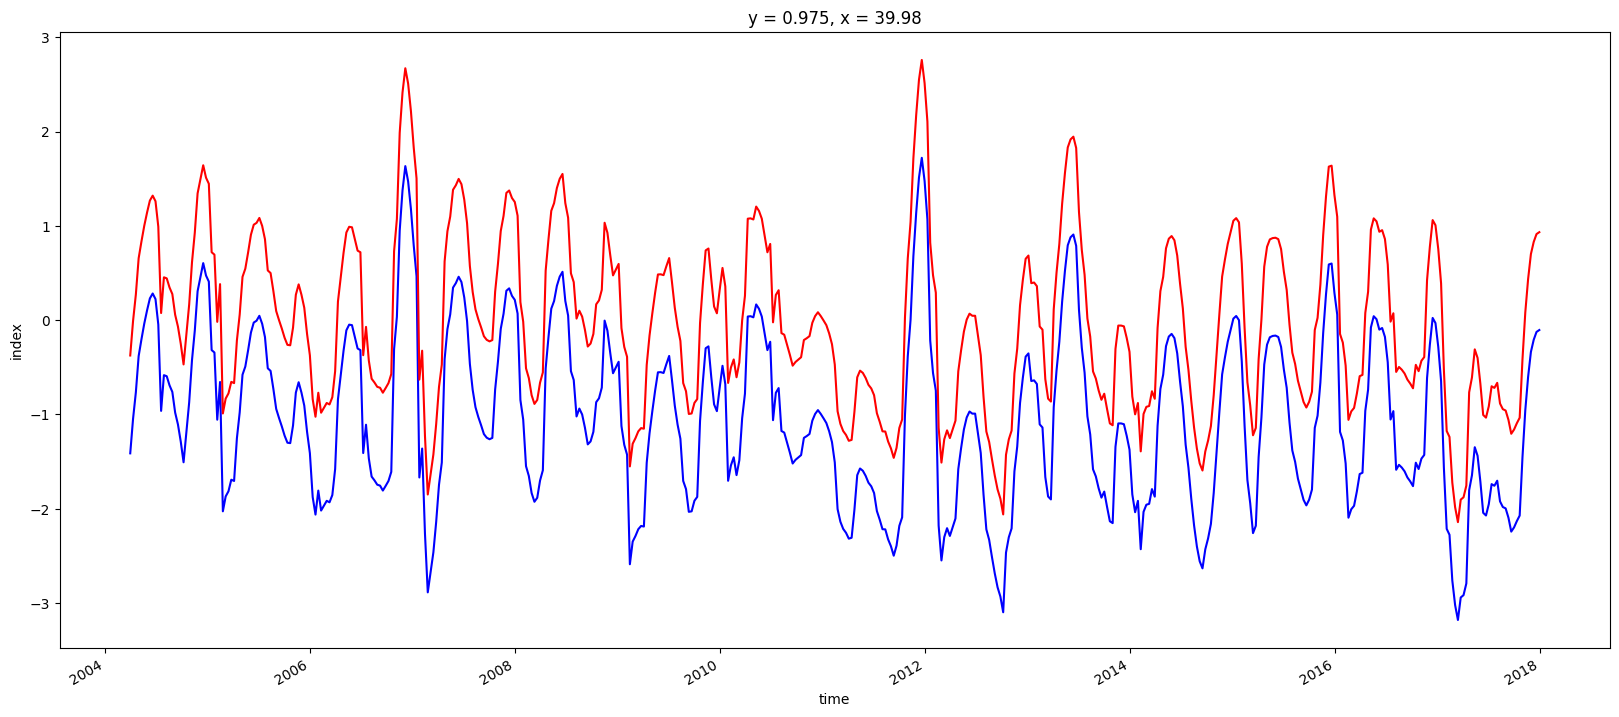

In [138]:
plt.figure(figsize=(20,8))
ghdi.__xarray_dataarray_variable__.sel(y=1, x=40, method='nearest').plot(color='blue')
ghdi.index.sel(y=1, x=40, method='nearest').plot(color='red')

In [144]:
ghdi.index.values

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan, -0.76641925,         nan, ...,         nan,
                 nan,         nan],
        [ 0.1722422 ,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 0.29871988,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan, -1.66508652,         nan, ...,  

ValueError: x must have 2 or fewer dimensions

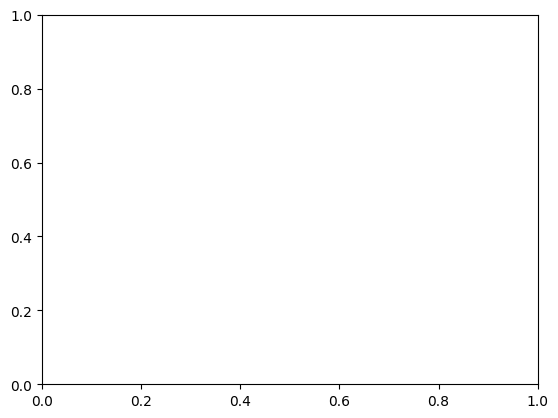

In [145]:
plt.hist(ghdi.index.values, bins=30)

(-4.0, 4.0)

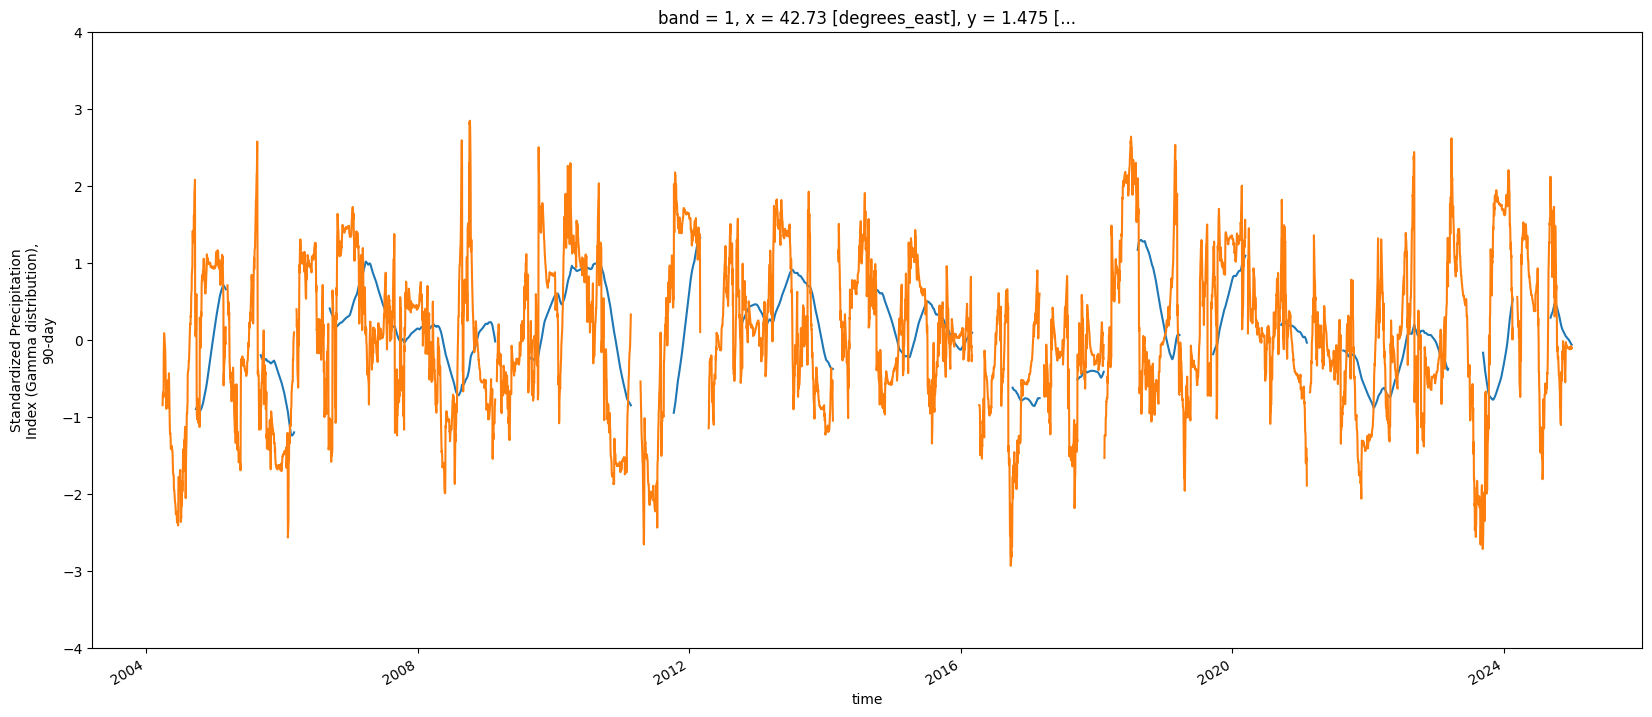

In [128]:
plt.figure(figsize=(20,8))
compute_sma(spi_90.spi_gamma_90, 180).sel(lat=1.46, lon= 42.72, method='nearest').plot(label='p-et_3month')
spi_90.spi_gamma_90.sel(lat=1.46, lon= 42.72, method='nearest').plot(label='p-et_3month')
# zone_1.et_90.sel(y=0.46, x= 41.72, method='nearest').plot(label='p-et_3month')
# zone_1.pet_90.sel(y=0.46, x= 41.72, method='nearest').plot(label='p-et_3month')
plt.ylim(-4,4)

(-4.0, 4.0)

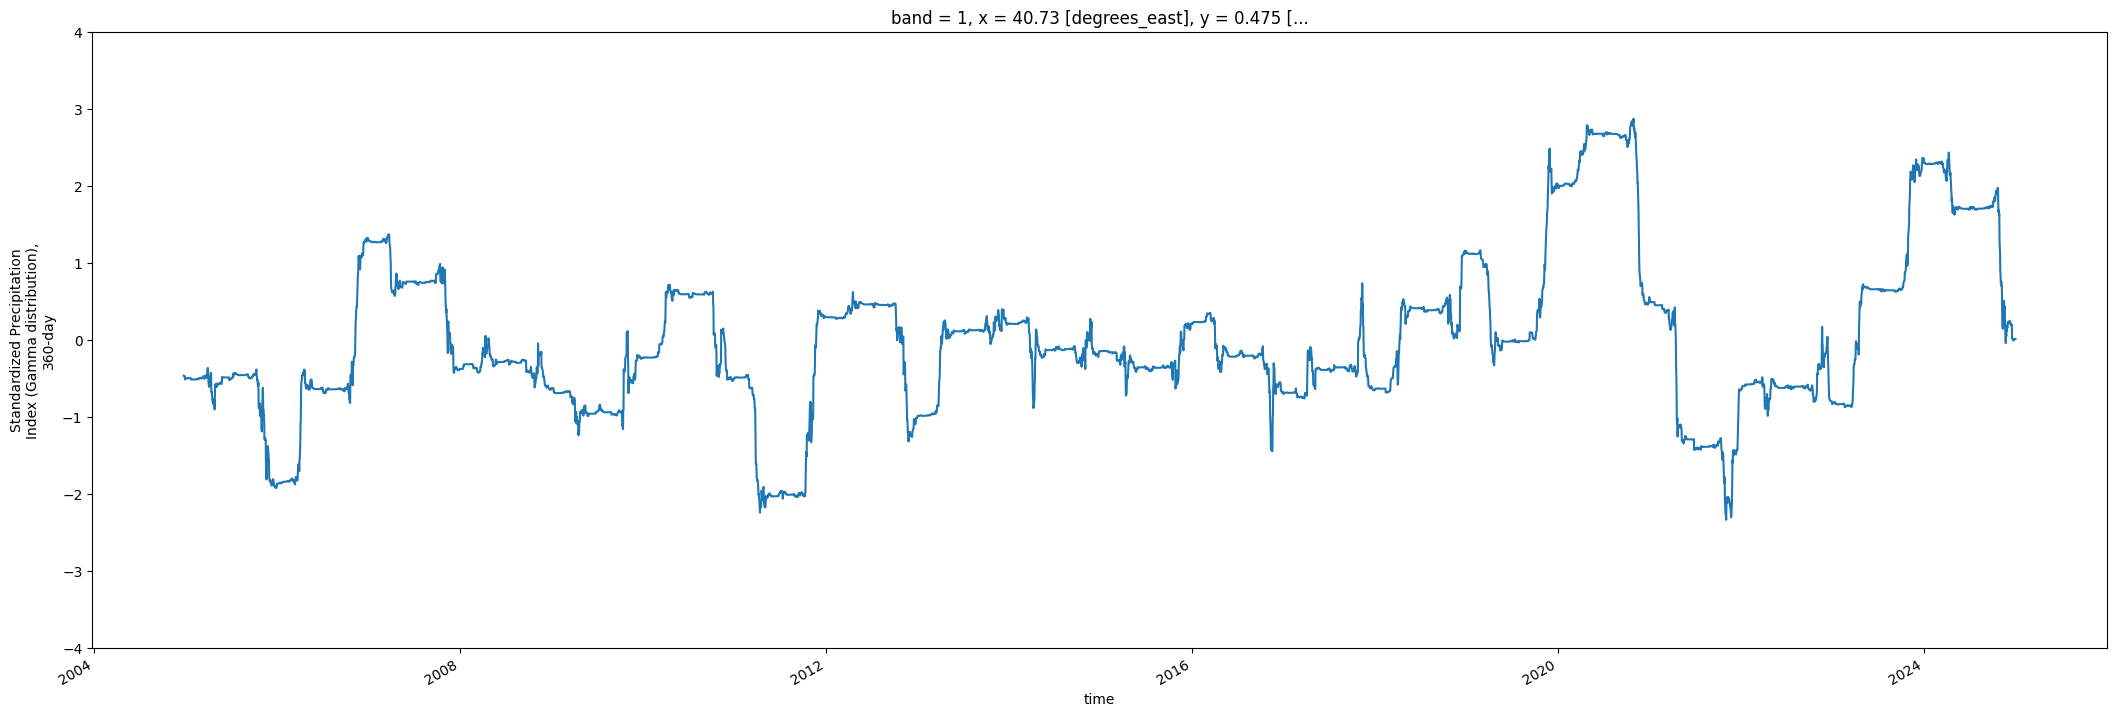

In [126]:
plt.figure(figsize=(26,8))
# spi_90.spi_gamma_90.sel(lat=0.46, lon= 40.72, method='nearest').plot(label='p-et_3month')
# spi_180.spi_gamma_180.sel(lat=0.46, lon= 40.72, method='nearest').plot(label='p-et_3month')
spi_360.spi_gamma_360.sel(lat=0.46, lon= 40.72, method='nearest').plot(label='p-et_3month')
plt.ylim(-4,4)

In [118]:
spi36 = spi_360.spi_gamma_360.resample(time='1M').mean()

(-4.0, 4.0)

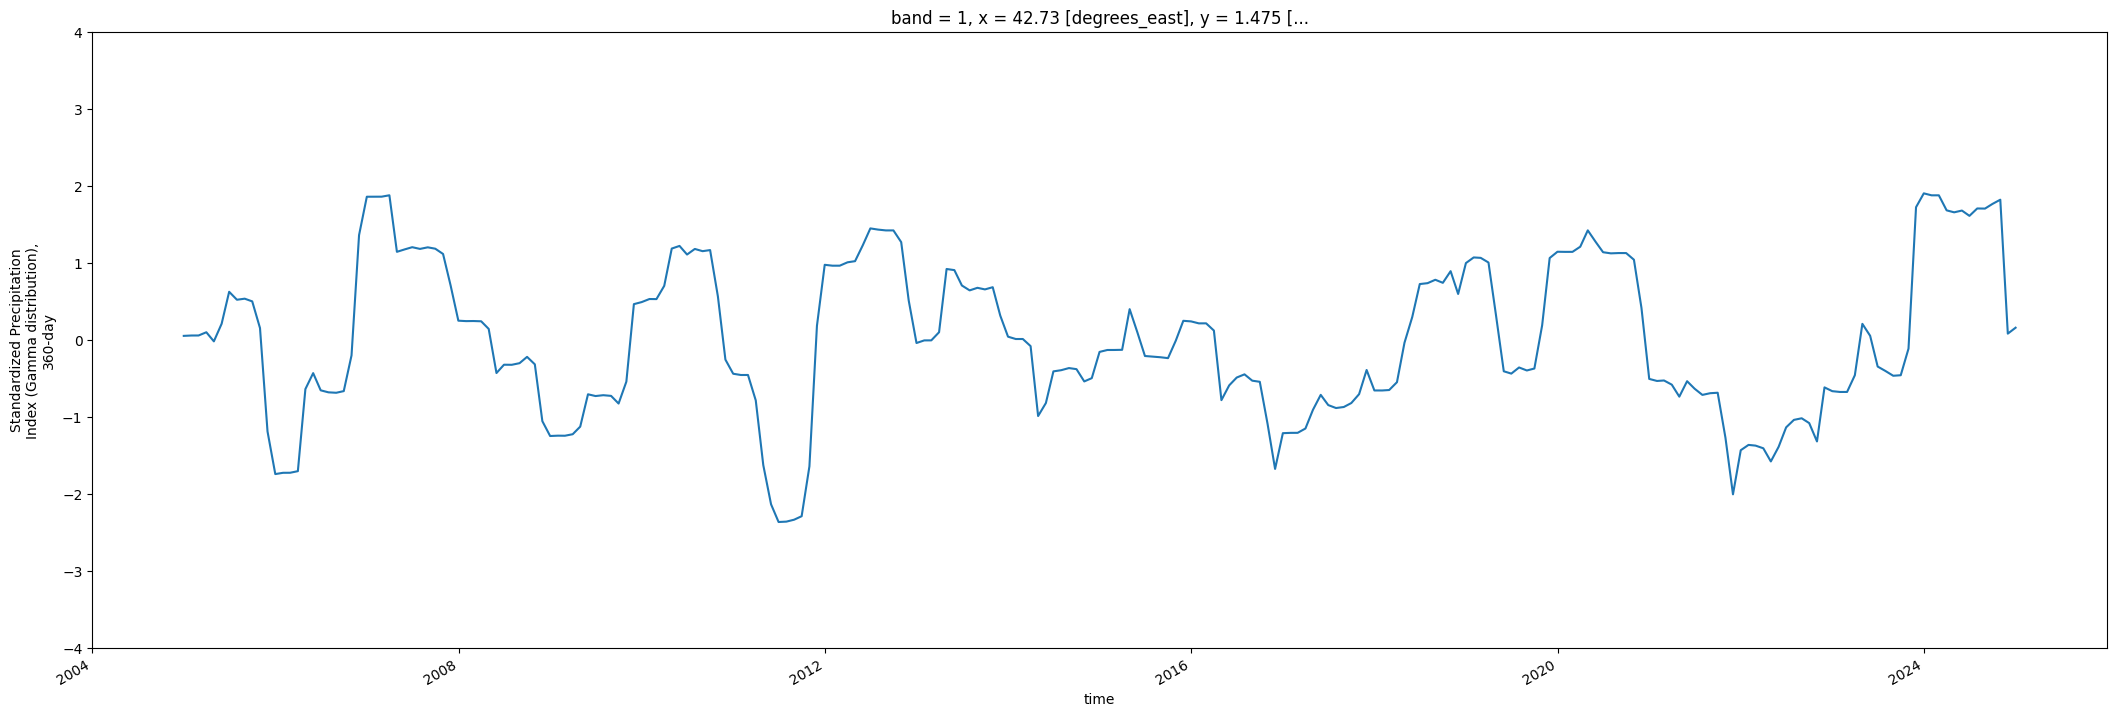

In [125]:
plt.figure(figsize=(26,8))
spi36.sel(lat=1.46, lon= 42.72, method='nearest').plot(label='p-et_3month')
plt.ylim(-4,4)

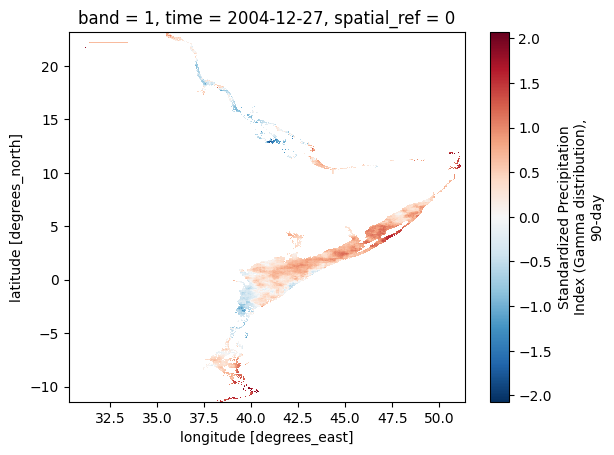

In [107]:
spi_90.spi_gamma_90.isel(time=361).plot()

In [ ]:
plt.figure(figsize=(20,8))
ds_standardized[360]['pet_360'].sel(y=0, x= 41.72, method='nearest').plot(label='p-et_3month')
ds_standardized[360]['sm_360'].sel(y=0, x= 41.72, method='nearest').plot(label='sm_3month')
ds_standardized[360]['tws_ds'].sel(y=0, x= 41.72, method='nearest').plot(label='tws_3month')
plt.axhline(0, color='k', linestyle='--')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

In [98]:
# Validation: Test period (2017–2024)
di = '../trials/drought_index_subregion_1_timescale_90.nc'

In [100]:
ghdi = xr.open_dataset(di, decode_times=False)

In [103]:
print(ghdi)

<xarray.Dataset>
Dimensions:         (sample_level_0: 179)
Coordinates:
  * sample_level_0  (sample_level_0) int64 -9223372036854775806 ... -92233720...
Data variables:
    *empty*
